Nice to meet you, I'm about to publish my notebook and this is my first attempt, so I hope you will be kind.I would appreciate it if you could tell me what I can do to improve it.
I basically followed @tetsu2131 notebook, so I'll elaborate on the differences.
https://www.kaggle.com/code/tetsutani/ps3e8-xgb-lgbm-cat-ensemble-baseline
Thanks for @tetsu2131.

I got a big shake down this time. If anyone can tell me why, I'd be glad to hear from you.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder

# Import libraries for Hypertuning
import optuna

# Import libraries for gradient boosting
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Load Data

In [2]:
df_train = pd.read_csv('data/train.csv',index_col='id')
df_train['is_original']= False
df_test = pd.read_csv('data/test.csv',index_col='id')
df_test['is_original']= False

print(df_train.loc[167044,])
df_train.loc[167044,'z']=3.13
print(df_test.loc[204824,])
df_test.loc[204824,'z']=3.18
print(df_train.loc[83284,])
df_train.loc[83284,'z']=4.04
print(df_train.loc[17041,])
df_train.loc[17041,'z']=4.87
print(df_train.loc[94237,])
df_train.loc[94237,'z']=5.1
print(df_train.loc[127668,])
df_train.loc[127668,'z']=5.15
print(df_test.loc[219059,])
df_test.loc[219059,'z']=4.91



carat             0.51
cut            Premium
color                G
clarity            VS2
depth             61.8
table             58.0
x                  5.2
y                 5.13
z                 31.3
price             1447
is_original      False
Name: 167044, dtype: object
carat           0.51
cut            Ideal
color              G
clarity          VS2
depth           61.6
table           54.0
x               5.15
y               5.17
z               31.8
is_original    False
Name: 204824, dtype: object
carat           1.07
cut            Ideal
color              H
clarity          SI1
depth           61.3
table           57.0
x               6.57
y               6.62
z               1.05
price           5125
is_original    False
Name: 83284, dtype: object
carat             2.01
cut            Premium
color                I
clarity            VS1
depth             59.1
table             60.0
x                 8.28
y                 8.21
z                 8.18
price           

I have retyped the values that are considered to be typos based on the estimated depth(2*z/(x+y)) error. However, this in turn made the PB results worse.

In [3]:
original = pd.read_csv('data/cubic_zirconia.csv',index_col=[0])

# depth has missing values
original = original[-original.depth.isna()]
df_train = pd.concat([df_train, original]).drop_duplicates()

In [4]:
# Drop the columns 'price' and 'id' from the training data
target_col = 'price'
X_train = df_train.drop([f'{target_col}'],axis=1).reset_index(drop=True)
y_train = df_train[f'{target_col}'].reset_index(drop=True)
X_test = df_test.reset_index(drop=True)

print(f"X_train shape :{X_train.shape} , y_train shape :{y_train.shape}")
print(f"X_test shape :{X_test.shape}")

del df_train, df_test

X_train shape :(219809, 10) , y_train shape :(219809,)
X_test shape :(129050, 10)


### Aggregate Featrues

In [5]:
class AggFeatureExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, group_col, agg_col, agg_func):
        self.group_col = group_col
        self.group_col_name = ''
        for col in group_col:
            self.group_col_name += col
        self.agg_col = agg_col
        self.agg_func = agg_func
        self.agg_df = None
        self.medians = None
        
    def fit(self, X, y=None):
        group_col = self.group_col
        agg_col = self.agg_col
        agg_func = self.agg_func
        
        self.agg_df = X.groupby(group_col)[agg_col].agg(agg_func)
        self.agg_df.columns = [f'{self.group_col_name}_{agg}_{_agg_col}' for _agg_col in agg_col for agg in agg_func]
        self.medians = X[agg_col].median()
        
        return self
    
    def transform(self, X):
        group_col = self.group_col
        agg_col = self.agg_col
        agg_func = self.agg_func
        agg_df = self.agg_df
        medians = self.medians
        
        X_merged = pd.merge(X, agg_df, left_on=group_col, right_index=True, how='left')
        X_merged.fillna(medians, inplace=True)
        X_agg = X_merged.loc[:, [f'{self.group_col_name}_{agg}_{_agg_col}' for _agg_col in agg_col for agg in agg_func]]
        
        return X_agg
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        X_agg = self.transform(X)
        return X_agg

In [6]:
class Preprocessor:
    def __init__(self, agg_col, agg_func, group_cols, comb_cat_cols, oh_cat_cols, ce_cat_cols):
        self.agg_col = agg_col
        self.agg_func = agg_func
        self.group_cols = group_cols
        self.comb_cat_cols = comb_cat_cols
        self.oh_cat_cols = oh_cat_cols
        self.ce_cat_cols = ce_cat_cols
        
    def preprocess(self, X_train, X_test):
        X_train = self.create_feature(X_train)
        X_test = self.create_feature(X_test)
        
        agg_train, agg_test = [], []
        for group_col in self.group_cols:
            agg_extractor = AggFeatureExtractor(group_col=group_col, agg_col=self.agg_col, agg_func=self.agg_func)
            agg_extractor.fit(pd.concat([X_train, X_test], axis=0))
            agg_train.append(agg_extractor.transform(X_train))
            agg_test.append(agg_extractor.transform(X_test))
        X_train = pd.concat([X_train] + agg_train, axis=1)
        X_test = pd.concat([X_test] + agg_test, axis=1)

        # create_categorical_combinations
        X_train, _ = self.create_categorical_combinations(X_train, self.comb_cat_cols)
        X_test, _ = self.create_categorical_combinations(X_test, self.comb_cat_cols)
        
        # OneHotEncoder
        onehot_train, onehot_test = self.encode_categorical_features(X_train, X_test, self.oh_cat_cols, encoder_type='onehot')

        # CountEncoder
        count_train, count_test = self.encode_categorical_features(X_train, X_test, self.ce_cat_cols, encoder_type='count')

        X_train = pd.concat([X_train, onehot_train, count_train], axis=1).drop(self.ce_cat_cols, axis=1)
        X_test = pd.concat([X_test, onehot_test, count_test], axis=1).drop(self.ce_cat_cols, axis=1)
        
        return X_train, X_test
        
    def create_feature(self, df):
        df.loc[(df['z']==0)&(df['x']!=0)&(df['y']!=0),'z']=df.loc[df['z']==0,'carat']/(0.0061*df.loc[df['z']==0,'x']*df.loc[df['z']==0,'y'])
        df.loc[(df['x']==0)&(df['y']!=0),'x']=6.792
        df.loc[(df['x']==0)&(df['y']!=0),'z']=2.548
        df=df.replace(0,np.nan)
        
        cut_map = {'Premium':4, 'Ideal':3, 'Very Good':2, 'Good':1, 'Fair':0}
        color_map = {'D':6, 'E':5, 'F':4, 'G':3, 'H':2, 'I':1, 'J':0}
        clarity_map = {'IF':9, 'VVS1':8, 'VVS2':7, 'VS1':6, 'VS2':5, 'SI1':4, 'SI2': 3, 'I1':2} 

        df['cut'] = df['cut'].map(cut_map)
        df['color'] = df['color'].map(color_map)
        df['clarity'] = df['clarity'].map(clarity_map)
        
        
        df['carat_e']=np.floor(4*df['carat'])/4
        print(df['carat_e'].describe())
        df['carat_e']=10*(df['carat']-df['carat_e'])/11+df['carat_e']
        df=df.drop(columns=['carat'])
        
        return df

    def create_categorical_combinations(self, df, categorical_columns, max_pattern=3):
        cols = []
        for comb in range(len(categorical_columns)):
            for col in combinations(categorical_columns, comb+1):
                if len(list(col)) > max_pattern:
                    break
                if len(list(col)) > 1:
                    col_names = list(col)
                    new_col = '_'.join(col_names)
                    df[new_col] = df[col_names[0]].astype(str)
                    for c in col_names[1:]:
                        df[new_col] = df[new_col] + '_' + df[c].astype(str)
                cols.append('_'.join(col))
        return df, cols
    
    def encode_categorical_features(self, X_train, X_test, categorical_columns, encoder_type):
        if encoder_type == 'onehot':
            encoder = OneHotEncoder(cols=categorical_columns)
            train_encoder = encoder.fit_transform(X_train[categorical_columns]).add_suffix('_ohe')
            test_encoder = encoder.transform(X_test[categorical_columns]).add_suffix('_ohe')
        elif encoder_type == 'count':
            encoder = CountEncoder(cols=categorical_columns)
            train_encoder = encoder.fit_transform(X_train[categorical_columns]).add_suffix('_count')
            test_encoder = encoder.transform(X_test[categorical_columns]).add_suffix('_count')
        else:
            raise ValueError("Unsupported encoder type. Available options: 'onehot', 'count'")

        return train_encoder, test_encoder

Zeros in x,y,x were taken as missing values.
For train, if y is 0, x and z are also 0. If x is 0, z is 0.
For test, if x is 0, then y and z are also 0. If y is 0, then x and z are also 0.Therefore, I decided to fill in only the ones that can be calculated from the carat and depth.This improved LB considerably.

Next is the introduction of carat_e. This is a feature of the carat, which represents the tendency of the value to increase by about 20% for every 0.25. This has improved the LB.

Increasing the number of features did not improve the score very much.

In [7]:
%%time
agg_col = ['carat_e']#['area_carat'], 'volume', 'density', 'depth_per_volume', 'depth_per_density', 'depth_per_table']
agg_func = ['mean', 'std']
group_cols = [['cut'], ['color'], ['clarity'], ['cut', 'color'], ['cut', 'clarity'], ['color', 'clarity'], ['cut', 'color', 'clarity']]
comb_categorical_columns = ['cut', 'color', 'clarity']
oh_categorical_columns = ['cut', 'color', 'clarity', 'is_original']
ce_categorical_columns = ['cut', 'color', 'clarity', 'is_original', 'cut_color', 'cut_clarity', 'color_clarity', 'cut_color_clarity']

pp = Preprocessor(agg_col, agg_func, group_cols, comb_categorical_columns, oh_categorical_columns, ce_categorical_columns)
X_train, X_test = pp.preprocess(X_train, X_test)

print(f"X_train shape :{X_train.shape} , y_train shape :{y_train.shape}")
print(f"X_test shape :{X_test.shape}")

count    219809.000000
mean          0.700438
std           0.476778
min           0.000000
25%           0.250000
50%           0.500000
75%           1.000000
max           4.500000
Name: carat_e, dtype: float64
count    129050.000000
mean          0.698514
std           0.475203
min           0.000000
25%           0.250000
50%           0.500000
75%           1.000000
max           4.500000
Name: carat_e, dtype: float64


C:\Users\USER\AppData\Local\Temp\ipykernel_17148\455741824.py:17: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  agg_extractor.fit(pd.concat([X_train, X_test], axis=0))
C:\Users\USER\AppData\Local\Temp\ipykernel_17148\455741824.py:17: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  agg_extractor.fit(pd.concat([X_train, X_test], axis=0))
C:\Users\USER\AppData\Local\Temp\ipykernel_17148\455741824.py:17: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object 

X_train shape :(219809, 49) , y_train shape :(219809,)
X_test shape :(129050, 49)
CPU times: total: 4.66 s
Wall time: 4.96 s


Many people put many things in agg_col, but I think only carat_e was the best. If anyone has a better method, please let me know.

### Split Data

In [17]:
class Splitter:
    def __init__(self, test_size=0.2, kfold=True, n_splits=3):
        self.test_size = test_size
        self.kfold = kfold
        self.n_splits = n_splits

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val
        else:
            for random_state in random_state_list:
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=random_state)
                yield X_train, X_val, y_train, y_val

kfold = True
n_splits = 5
random_state = 2023
random_state_list = [42, 71, 25] # split_data

splitter = Splitter(kfold=kfold, n_splits=n_splits)

### Set Hyperparameters

In [20]:
# Hyperparameters
n_estimators = 9999
device = "cpu"

xgb_params = {
    'n_estimators': n_estimators,
    'learning_rate': 0.05,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror'
    
}

lgb_params = {
    'n_estimators': n_estimators,
    'learning_rate': 0.05,
    'max_depth': 10,
    'subsample_for_bin': 20000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'regression',
    'device': device
}

cb_params = {
    'n_estimators': n_estimators,
    'learning_rate': 0.05,
    'max_depth': 8,
    'loss_function': 'RMSE',
    'task_type': device.upper()
}

### Model

In [10]:
def train_regressor(regressor, X_train, y_train, X_val, y_val, regressor_params, early_stopping_rounds=100, random_state=42):
    regressor = regressor(**regressor_params, random_state=random_state)
    eval_set = [(X_val, y_val)]
    regressor.fit(X_train, y_train, early_stopping_rounds=early_stopping_rounds, eval_set=eval_set, verbose=False)
    val_preds = regressor.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    return regressor, rmse

In [21]:
from tqdm import tqdm
import time
xgb_models, lgb_models, cb_models = [], [], []
xgb_scores, lgb_scores, cb_scores = [], [], []
for X_train_, X_val, y_train_, y_val in tqdm(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    xgb_model, xgb_rmse = train_regressor(xgb.XGBRegressor, X_train_, y_train_, X_val, y_val, xgb_params)
    lgb_model, lgb_rmse = train_regressor(lgb.LGBMRegressor, X_train_, y_train_, X_val, y_val, lgb_params)
    cb_model, cb_rmse = train_regressor(CatBoostRegressor, X_train_, y_train_, X_val, y_val, cb_params)
    xgb_models.append(deepcopy(xgb_model)), lgb_models.append(deepcopy(lgb_model)), cb_models.append(deepcopy(cb_model))
    xgb_scores.append(xgb_rmse), lgb_scores.append(lgb_rmse), cb_scores.append(cb_rmse)

15it [11:37, 46.50s/it]


### Ensemble

In [12]:
class OptunaWeights:
    def __init__(self, random_state):
        self.study = None
        self.weights = None
        self.random_state = random_state

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        # Calculate the ROC AUC score for the weighted prediction
        score = np.sqrt(mean_squared_error(y_true, weighted_pred))
        return score

    def fit(self, y_true, y_preds, n_trials=300):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        self.study = optuna.create_study(sampler=sampler, study_name="OptunaWeights", direction='minimize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds, n_trials=300):
        self.fit(y_true, y_preds, n_trials=n_trials)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

In [22]:
models = np.array([xgb_models, lgb_models, cb_models]).T.tolist()
names = ['XGBoost', 'LightGBM', 'CatBoost']

# Initialize variables
test_predss = np.zeros(X_test.shape[0])
ensemble_score = []
weights = []

# Loop through the folds
i = 0
for _model, (X_train_, X_val, y_train_, y_val) in zip(models, splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits
    val_preds, test_preds, zero_test_preds = [], [], []
    for model in _model:
        oof_pred = model.predict(X_val.values)
        test_pred = model.predict(X_test.values)
        val_preds.append(oof_pred)
        test_preds.append(test_pred)
        
    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state)
    val_pred = optweights.fit_predict(y_val.values, val_preds)
    score = np.sqrt(mean_squared_error(y_val, val_pred))
    print(f'[FOLD-{n} SEED-{random_state_list[m]}] RMSE score {score:.5f}')
    ensemble_score.append(score)
    weights.append(optweights.weights)
    
    # Predict on the test set using the optimized ensemble weights
    test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))
    i += 1
    
# Calculate the mean AUC score of the ensemble
mean_score = np.mean(ensemble_score)
std_score = np.std(ensemble_score)
print(f'Ensemble RMSE score {mean_score:.5f} ± {std_score:.5f}')

# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(names, mean_weights, std_weights):
    print(f'{name} {mean_weight:.5f} ± {std_weight:.5f}')

[FOLD-0 SEED-42] RMSE score 564.88471
[FOLD-1 SEED-42] RMSE score 564.15259
[FOLD-2 SEED-42] RMSE score 567.56445
[FOLD-3 SEED-42] RMSE score 563.47919
[FOLD-4 SEED-42] RMSE score 579.13788
[FOLD-0 SEED-71] RMSE score 562.85857
[FOLD-1 SEED-71] RMSE score 572.12926
[FOLD-2 SEED-71] RMSE score 566.79173
[FOLD-3 SEED-71] RMSE score 569.72559
[FOLD-4 SEED-71] RMSE score 564.75288
[FOLD-0 SEED-25] RMSE score 561.33192
[FOLD-1 SEED-25] RMSE score 569.07155
[FOLD-2 SEED-25] RMSE score 562.75171
[FOLD-3 SEED-25] RMSE score 560.53025
[FOLD-4 SEED-25] RMSE score 584.34516
Ensemble RMSE score 567.56716 ± 6.43408
--- Model Weights ---
XGBoost 0.39533 ± 0.15268
LightGBM 0.55332 ± 0.14740
CatBoost 0.64085 ± 0.10151


### Make Submission

In [23]:
submission_df = pd.read_csv("data/sample_submission.csv", index_col='id')
submission_df['price'] = test_predss
submission_df.to_csv('submission.csv')

<Axes: xlabel='price', ylabel='Count'>

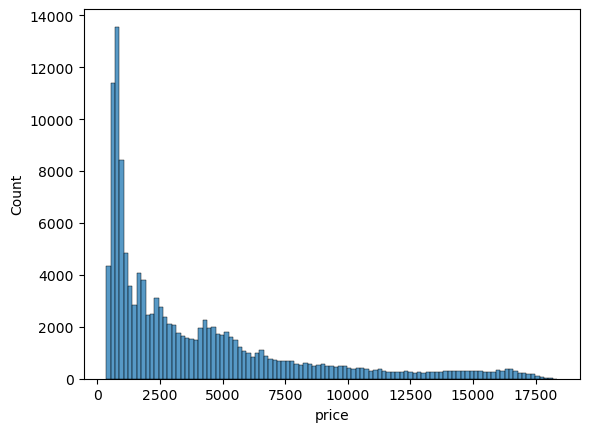

In [24]:
sns.histplot(submission_df.price)

Thanks for reading. If you have any questions or comments, please contact me!